# Term Deposit Subscription Modelling




Contributer: Eriko Funasato

Research Question / Hypothesis
----




* What features are important to get customers subscribe in the term deposit.
* How campaign affect the conversion? 
* Try to build a model to predict whether customers will subscribe for term deposit.

About the Data
-----

In [22]:
# Imports
from   category_encoders          import *
import numpy as np
import pandas as pd
from   sklearn.compose            import *
from   sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from   sklearn.experimental       import enable_iterative_imputer
from   sklearn.impute             import *
from   sklearn.linear_model       import LogisticRegression, RidgeClassifier, SGDClassifier
from   sklearn.metrics            import balanced_accuracy_score, mean_absolute_error
from   sklearn.pipeline           import Pipeline
from   sklearn.preprocessing      import *
from   sklearn.tree               import DecisionTreeClassifier, ExtraTreeClassifier
from   sklearn.model_selection    import train_test_split,RandomizedSearchCV, GridSearchCV
from   sklearn.base               import BaseEstimator
from   sklearn.metrics            import *
from   sklearn.neighbors          import KNeighborsClassifier
from   sklearn.svm                import SVC
from   sklearn.ensemble       import VotingClassifier


import seaborn as sns
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport

In [3]:
# To make csv comma separated: $ tr ';' ',' < bank.csv > output.csv 
df = pd.read_csv('bank_comma.csv')

In [ ]:
df.head()

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [87]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000



## Attribute Information:


**bank client data:**

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','selfemployed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

**related with the last contact of the current campaign:**

8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**social and economic context attributes**

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

Fit scikit-learn model
----

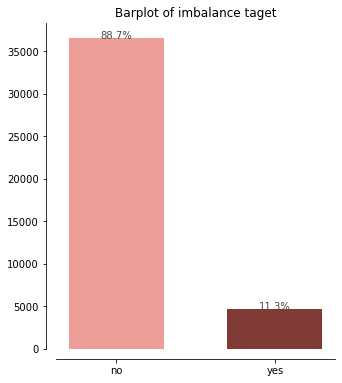

In [93]:
fig, ax = plt.subplots(figsize=(5,6))

ax.bar(y.unique(), y.value_counts(),width=0.6,color=['#ed9d98','#803b37'])
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+p.get_width()/3, p.get_height()+9),color='#4f4646')
    
ax.set_title("Barplot of imbalance taget")
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("imbalance.png")
plt.show()

Preprocessing 
---

In [94]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [89]:
df.isnull().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [4]:
# replace the no previous call rows(noted 999) in pdays
df['pdays'].replace({999:0}, inplace=True)

In [5]:
X = df.drop(columns=['y'])
y = df['y']

In [6]:
# Split the data into train, validation, and test set
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [7]:
y_train.replace({"no":0,"yes":1}, inplace=True)
y_val.replace({"no":0,"yes":1}, inplace=True)
y_test.replace({"no":0,"yes":1}, inplace=True)

In [8]:
categorical_columns = (X.dtypes == object)

con_pipe = Pipeline([('imputer', SimpleImputer(strategy='median', add_indicator=True)),
                     ('scaler', StandardScaler())])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent',missing_values="unknown", add_indicator=True)),
                     ('ohe', OneHotEncoder())])

preprocessing = ColumnTransformer([('categorical', cat_pipe,  categorical_columns),
                                   ('continuous',  con_pipe, ~categorical_columns),
                                   ])

## 1. Baseline - Logistic Regression
---

In [25]:
pipe1 = Pipeline([('preprocessing',preprocessing),
                 ('lr',LogisticRegression(class_weight="balanced"))]) 
pipe1.fit(X_train,y_train)

C:\Users\eriko\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  age               False
job                True
marital            True
education          True
default            True
housing            True
loan               True
contact            True
month              True
day_of_week        True
duration          False
campaign          False
pd...
 

In [26]:
pipe1.score(X_train,y_train)

0.8626553867403315

In [27]:
pipe1.score(X_val,y_val)

0.8636540204583711

## 2. Random Grid Search -> RandomForest
---
Use RandomizedSearchCV to search for the hyperparameter and the best performing model 

In [10]:
# Dummy estimator to tune hyperparameter 
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5,10,15,20,25,50,75,100]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
max_samples_leaf = [10, 20, 30, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]

pipe_dummy = Pipeline([('preprocessing',preprocessing),
                        ('clf', DummyEstimator())])

search_space = [{'clf': [ExtraTreesClassifier(),RandomForestClassifier()], # Actual Estimator
                 'clf__max_depth': max_depth,
                 'clf__n_estimators':n_estimators,
                 'clf__bootstrap':bootstrap,
                 'clf__max_features': max_features,
                 'clf__max_leaf_nodes': max_samples_leaf,
                 'clf__criterion': ['gini', 'entropy']}]
    

clf_algos_rand = RandomizedSearchCV(estimator=pipe_dummy, 
                                    param_distributions=search_space, 
                                    n_iter=40,
                                    cv=7, 
                                    n_jobs=-1,
                                    scoring='f1_weighted',
                                    verbose=1)


best_model = clf_algos_rand.fit(X_train, y_train);
best_model.best_params_, best_model.best_score_


Fitting 7 folds for each of 40 candidates, totalling 280 fits


({'clf__n_estimators': 400,
  'clf__max_leaf_nodes': 50,
  'clf__max_features': 'sqrt',
  'clf__max_depth': 50,
  'clf__criterion': 'gini',
  'clf__bootstrap': False,
  'clf': RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                         max_leaf_nodes=50, n_estimators=400)},
 0.8874704280669582)

Train Random Forest model 
---

In [28]:
pipe2 = Pipeline([('preprocessing',preprocessing),
                 ('rf', RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                         max_leaf_nodes=50, n_estimators=400))])
pipe2.fit(X_train, y_train)
pipe2.score(X_val,y_val)

0.9041823125728344

## 3. Ensemble

In [29]:
knn_clf = KNeighborsClassifier()
dt_clf  = DecisionTreeClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators = [('knn', knn_clf), 
                                            ('dt', dt_clf), 
                                            ('svc',svm_clf)],
                              voting = 'hard')
pipe3 = Pipeline([('preprocessing',preprocessing),
                 ('clf', voting_clf)])
pipe3.fit(X_train, y_train)
pipe3.score(X_val, y_val)

0.9088437135828046

## 4. Evaluation Metric
----

In [31]:
y_pred1 = pipe1.predict(X_val)
y_pred2 = pipe2.predict(X_val)
y_pred3 = pipe3.predict(X_val)

In [32]:
# Confusion Matrix
print("Logistic Regression:\n",confusion_matrix(y_val,y_pred1))
print("Random Forest:\n",confusion_matrix(y_val,y_pred2))
print("Ensembled Model\n:",confusion_matrix(y_val,y_pred3))

Logistic Regression:
 [[5912  935]
 [ 118  758]]
Random Forest:
 [[6774   73]
 [ 667  209]]
Ensembled Model
: [[6631  216]
 [ 488  388]]


In [33]:
# Pipeline score 
print("logistic Regression:",pipe1.score(X_test,y_test))
print("Random Forest:",pipe2.score(X_test,y_test))
print("Ensemble model:",pipe3.score(X_test,y_test))

logistic Regression: 0.8584053607846945
Random Forest: 0.9041468388851122
Ensemble model: 0.908808390793435


In [38]:
# F1_score
print("logistic Regression:",f1_score(y_val, y_pred1, average='weighted'))
print("Random Forest:",f1_score(y_val, y_pred2, average='weighted'))
print("Ensemble model:",f1_score(y_val, y_pred3, average='weighted'))

logistic Regression: 0.8810092358165441
Random Forest: 0.8815990408835677
Ensemble model: 0.9013548639566907


In [64]:
from sklearn.inspection import permutation_importance
r = permutation_importance(pipe1, X_val, y_val,
                           n_repeats=30,
                           random_state=0)

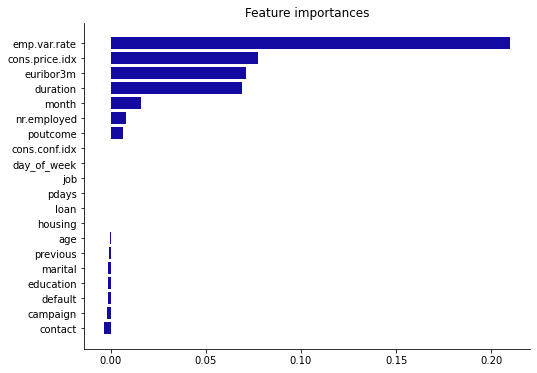

In [88]:

index = r.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8,6))

ax.barh(X_train.columns[index],r.importances_mean[index],
        color="#130ba1", align="center")
ax.set_title("Feature importances")
# ax.spines['left'].set_position(('outward', 10))
# ax.spines['bottom'].set_position(('outward', 10))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig("feature_impotance.png")
plt.show()

Test Set Evaluation
---

In [95]:
pipe3.score(X_test, y_test)

0.908808390793435